<a href="https://colab.research.google.com/github/geyzon-assis/estudos/blob/master/An%C3%A1lise_Quantitativa_de_ativos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1.Instalação e importação de bibliotecas

In [ ]:
!pip install python-binance
!pip install plotly

     |████████████████████████████████| 63 kB 1.1 MB/s 
     |████████████████████████████████| 103 kB 12.3 MB/s 
     |████████████████████████████████| 43 kB 2.1 MB/s 
     |████████████████████████████████| 288 kB 34.0 MB/s 
     |████████████████████████████████| 1.1 MB 41.0 MB/s 
     |████████████████████████████████| 271 kB 54.5 MB/s 
     |████████████████████████████████| 144 kB 43.6 MB/s 
     |████████████████████████████████| 94 kB 3.2 MB/s 


In [ ]:
import pandas as pd
from binance.client import Client
import plotly.graph_objects as go 
from plotly.subplots import make_subplots

In [ ]:
client = Client()

In [ ]:
btcblr = client.get_historical_klines(symbol="BTCBRL", interval=Client.KLINE_INTERVAL_1DAY ,start_str="2021-01-01" ,end_str="2022-02-10" )

In [ ]:
type(btcblr)

list

In [ ]:
# Converter os dados da lista em dataframe, seguindo esse modelo OHLC padrão no mercado financeiro
btc_brl = pd.DataFrame(btcblr)

In [ ]:
# Renomear os essas colunas de acordo com seus dados
btc_brl.rename(columns={0:'date',1:'open',2:'high',3:'low',4:'close'}, inplace=True)

In [ ]:
# Setar a data como indice e convertendo em data modelo padrão
btc_brl.set_index('date',inplace=True)
btc_brl.index = pd.to_datetime(btc_brl.index, unit = 'ms')

# Dropar da quarta coluna em diante pois são dados que não serão utilizados nesse momento
btc_brl.drop(btc_brl.columns[4:], axis = 1, inplace = True)

In [ ]:
btc_brl.head()

,open,high,low,close
date,,,,
2021-01-01,152056.00000000,154167.00000000,150911.00000000,153480.00000000
2021-01-02,153478.00000000,173900.00000000,152171.00000000,168784.00000000
2021-01-03,168885.00000000,180925.00000000,167897.00000000,173503.00000000
2021-01-04,173504.00000000,175981.00000000,150000.00000000,169820.00000000
2021-01-05,169825.00000000,182966.00000000,159769.00000000,179972.00000000


In [ ]:
btc_brl.dtypes

open     object
high     object
low      object
close    object
dtype: object

In [ ]:
# Converter os tipos objetos em numeros
btc_brl['open']   = pd.to_numeric(btc_brl['open'])
btc_brl['high']   = pd.to_numeric(btc_brl['high'])
btc_brl['low']    = pd.to_numeric(btc_brl['low'])
btc_brl['close']  = pd.to_numeric(btc_brl['close'])

#2. Análise Quantitativa

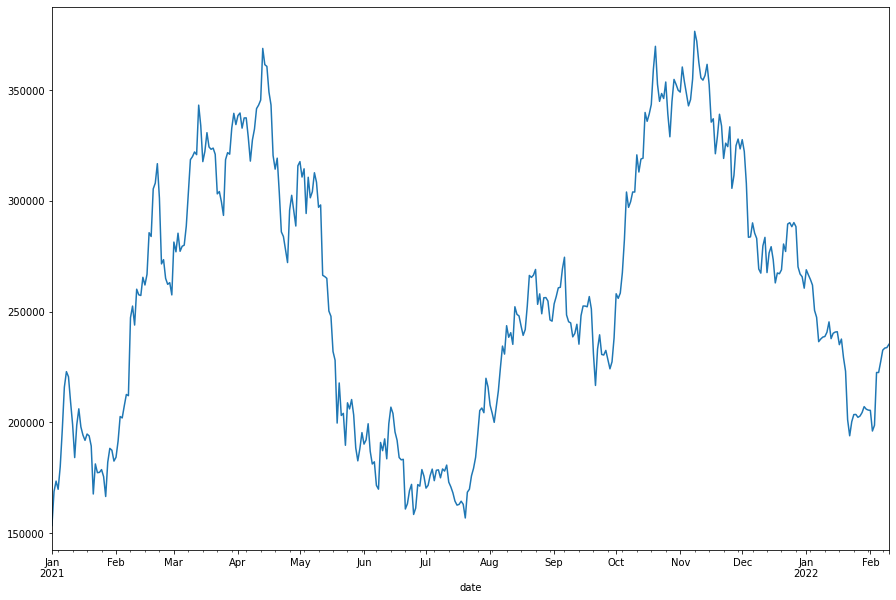

In [ ]:
btc_brl['close'].plot(figsize = (15,10))

In [ ]:
# Criar uma nova coluna do DF com o retorno diário do fechamento anterior com o atual, utilizando o método do pandas pct_change
btc_brl['retornos'] = btc_brl['close'].pct_change()

In [ ]:
btc_brl['retornos'].head()

date
2021-01-01         NaN
2021-01-02    0.099713
2021-01-03    0.027959
2021-01-04   -0.021227
2021-01-05    0.059781
Name: retornos, dtype: float64

In [ ]:
# É possivel observar os dados estatísticos referentes os retornos diários observados
# é possivel observar o que a média diária é levemente positiva
btc_brl['retornos'].describe()

count    405.000000
mean       0.001824
std        0.039355
min       -0.124411
25%       -0.019856
50%        0.000590
75%        0.021592
max        0.165940
Name: retornos, dtype: float64

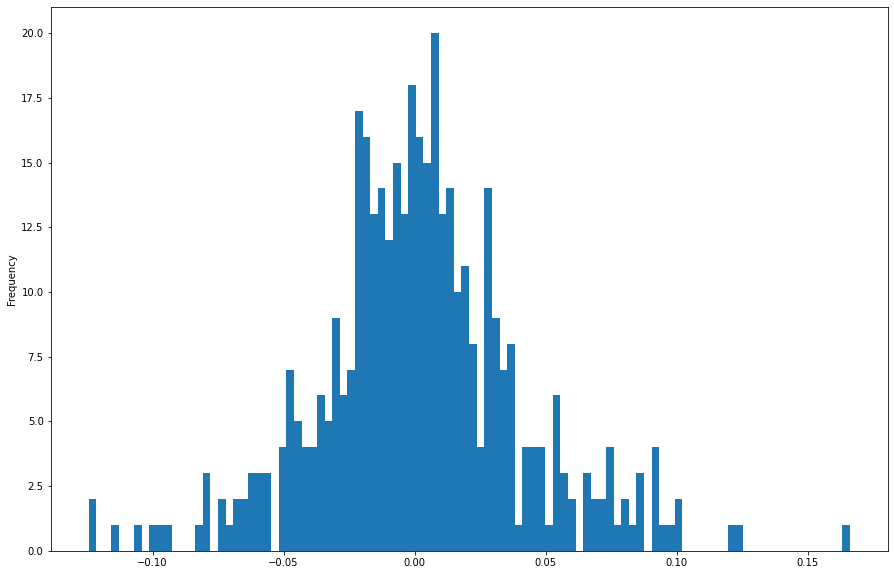

In [ ]:
# É possivel observar a distribuição num histograma dos retornos diários
btc_brl['retornos'].plot.hist(bins=100, figsize=(15,10))

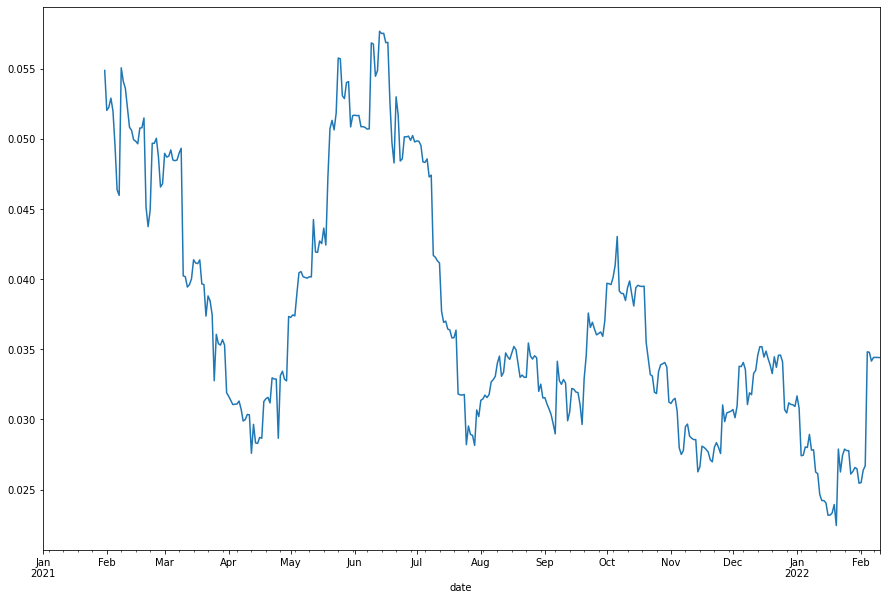

In [ ]:
# Calculando a Janela de Volatilidade utilizando o método do pandas rolling
# basicamente estamos pegando janelas (slicing) dos 30 períodos anteriores (30 dias nesse caso) e aplicando algum calculo,
# que nesse caso é o desvio padrão
vol_30 = btc_brl['retornos'].rolling(window = 30).std()
vol_30.plot(figsize=(15,10))

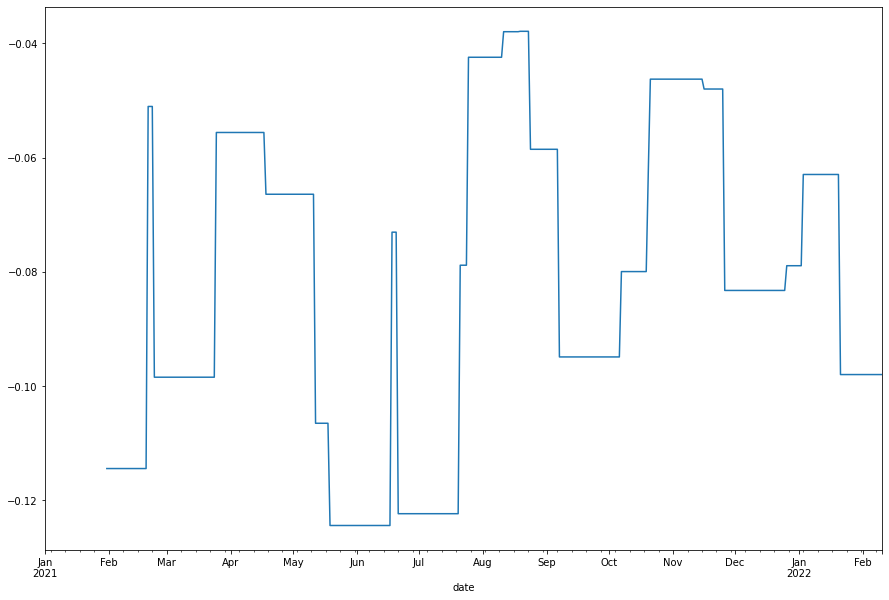

In [ ]:
# Drawdown em janelas de 30 dias
# Perda máxima em um determinado período - distancia entre ganho máximo e a mínima

dd_30 = btc_brl['retornos'].rolling(window = 30).min()
dd_30.plot(figsize = (15,10))

# 3. Criação dos sinais do trading e backtesting

## 3.1 Introdução

In [ ]:
# Lembrete: procure parametrizar tudo o que voce faz

## Variação mínima do preço || Ações = R$0,01 || WINFUT = 5pts || 

tick_min = 1 #variação mínima para ações no preço
MM_periodo = 9

##3.2 Construção do sinal de COMPRA

Regra 1 : Preço Fechamento > MM
<br> Regra 2 : Preço Fech candle anterior < MMA9p

In [ ]:
## Cálculo Média móvel de 9 períodos
MMA = btc_brl['close'].rolling(window=MM_periodo).mean()

In [ ]:
btc_brl['MMA'] = MMA

In [ ]:
#GRÁFICO MÉDIA MOVEL
#cria figura
fig = make_subplots(rows=1, cols=1)
#Adiciona o gráfico de candlestick com os parametros OHLC no eixo y e no eixo x o index com as datas
fig.add_trace(go.Candlestick(name='Bitcoin_BRL', x=btc_brl.index, open=btc_brl['open'], high = btc_brl['high'], low=btc_brl['low'], close=btc_brl['close'],showlegend=True), row=1,col=1)
# cria o gráfico de MMA com o mesmo racional de eixo de cima
fig.add_trace(go.Scatter(name='MMA_9p', x=btc_brl.index, y=btc_brl.MMA, marker_color='blue'),row=1,col=1)
#Personalizar o eixo Y
fig.update_yaxes(title_text="<b> Preço Bitcoin (R$)", row=1, col=1)
#Personalizar aspectos da figura em geral
fig.update_layout(xaxis_rangeslider_visible=False,width=1000 ,height=500)
#Mostra a figura
fig.show()